# 1. Introduction

Natural language generation (NLG), a sub-field of natural language processing (NLP), is defined as the task of building software systems that can produce understandable texts in English or other human languages ([Reiter and Dale, 1997](#References)).
It is a vital tool in a wide range of natural language applications such as machine translation, text summarization
and question-answering. Recently, Transformer-based neural language models have shown to be very effective in leveraging large amounts of raw text corpora from online sources such as Wikipedia, search results, blogs, Reddit posts etc.([Celikyilmaz et al., 2020](#References)). On February 14th 2019, GPT-2 ([Radford et al., 2019](#References)) surprised the scientific community with an impressively high-quality article about Ovid’s Unicorn, the model has shown the ability to generate long texts that are almost indistinguishable from human-generated texts
([Uchendu et al., 2020](#References)).

On that account, the main purpose of this paper is to apply python implementations for transformer-based text generation model and compare the generated text with other architectures. In the experimental setup, we included the GPT2 model published by OpenAI as the transformer model and a recurrent neural network (RNN) as the benchmark model. The two models are fine-tuned on three different datasets: Netflix description, Pop-Song Lyrics, and Business News.

# 2. Literature Review

NLG techniques range from simple template-based systems to machine-learned systems. Earlier template-based models ([Ono et al., 1994](#References), [Marcu, 1997](#References), [Stede and Umbach, 1998](#References)) have focused on modeling discourse structures and learning representations of relations between text units for text generation
([Celikyilmaz et al., 2020](#References)). Following this earlier work, with the availability of large datasets and corpus, several NLG researchers have focused on data-driven representation learning ([Gatt et al., 2007](#References), [Mairesse et al., 2010](#References), [Konstas and Lapata, 2013](#References)).

More recent work has shifted towards learning representations with the use of deep neural network (DNN) models ([Celikyilmaz et al., 2020](#References)), including RNNs (popular choices include LSTM ([Hochreiter and Schmidhuber, 1997](#References)) and GRU ([Chung et al., 2014](#References)). Most recently, Transformer architectures ([Vaswani et al., 2017](#References)) that incorporate the encoder-decoder structure and self attention mechanism are the new state-of-the-art NLG systems.

In their paper, Holtzman et al. categorized text generation tasks into directed generation and open-ended generation
[Holtzman et al., 2019](#References), where directed generation include applications like machine translation ([Bahdanau et al., 2014](#References)), summarization ([Nallapati et al., 2016](#References)), and data-to-text generation ([Wiseman et al., 2017](#References)), and open-ended generation includes conditional story generation and contextual text continuation. Unlike in directed generation settings, there is a considerable degree of freedom in the development of the story for open-ended generation. Typically, prompts generated by models or written by humans can only be used to provide a rough guide or starting point for the generated text ([Keskar et al., 2019](#References)), and controllability over the generation output is in general lacking.

This arouses the academic interests in controllable text generation, especially seeing the success in the degree
of control available image generation ([Chen et al., 2016](#References), [Paige et al., 2017](#References), [Lample et al., 2017](#References)). For example, Peng et al. proposed an analyze-to-generate framework that enables controllable story generation ([Peng et al., 2018](#References)). In this pilot study, the researchers explored the control on ending valence and story line for both style-level and content-level elements. Furthermore, CTRL model released in 2019 [Keskar et al., 2019](#References) incorporated ”control codes” that govern style, content, and task-specific behavior into the training process. And these codes allow users to explicitly specify domain, entities, relationships between entities, dates, and task-specific behavior.

On the other hand, there’s also a large body of research on avoiding neural text degeneration. Generated text in open-ended applications has been observed to be dull, with high frequency tokens used too often and interesting content words used too rarely ([Holtzman et al., 2019](#References)), which results in the repetition at token, phrase, and sentence levels ([Welleck et al., 2019](#References)). These issues were not resolved with the increase of either training data or model size, as the same problem occurs also in the large-scale GPT2 model ([Radford et al., 2019](#References)). Several methods have hence been proposed: Unlikelihood Training introduced by Welleck et al. forces unlikely generations to be assigned lower probability by the model and yields a result of less repetitive text while maintaining perplexity ([Welleck et al., 2019](#References)); Nucleus Sampling truncates the tail of the probability distribution and samples only from the dynamic nucleus of tokens containing the vast majority of the probability mass. With this approach, they achieved both high-quality and diverse text.

# 3. Experiments

**[Important Notes on (running) the Experiment]**
1.  Due to resourse limit on runtime and GPU memory, make sure to have a whole new runtime set up before running the notebook for each dataset. On top of that, it is recommended to save the progress and restart the runtime occasionally, otherwise the runtime might stop automatically. Some good cutting points are as follow: 
    1. After the gpt2 model is trained.
    2. After the generation results are produced.
2. In order to keep the notebook neat, we only show the code on the model part for one dataset, but re-running the cells with a simple comment in/out of the `df_name` will produce results for the other two datasets. In addition, the result files are also uploaded on the github website if skipping running the model part is desired.

## 3.1 Setup

In our experimental setup, we include two models: GPT2 and RNN. The models are going to be fine-tuned on three datasets: Business News, Netflix Description and Pop-song Lyrics. Below is an overview on the experiment structure.

**Main Steps**
- Load in packages and the datasets
- Model
    - GPT2
        - Prepare the dataset and build ``TextDataset``
        - Load the pre-trained GPT-2 model and tokenizer
        - Start fine-tuning with ``Trainer``
        - Generate text
    - RNN
        - Load in previously built ``TextDataset``
        - Construct the simple RNN structure
        - Generate text
- evaluate the model
    - BLEU
    - Grammar Check

Load in packages and the datasets

In [ ]:
# !pip install transformers==4.2.2

In [1]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import helper_function as helpers

seed = 123
df_name = 'news_data'
# df_name = 'netflix_data'
# df_name = 'lyrics_data'

To check the info of the GPU we are currently using, simply type in ``!nvidia-smi``.

In [2]:
!nvidia-smi

Fri Feb 11 15:42:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   29C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 3.1.1 Text Generation

#### 3.1.1.1 GPT2

Load the datasets

We will use three datasets in the project: 
1. "[News Aggregator Dataset (only Business news)](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)" from UCI Machine Learning Repository
2. "[Netflix Dataset](https://www.kaggle.com/nulldata/fine-tuning-gpt-2-to-generate-netlfix-descriptions/data)" from Kaggle
3. "[Song Lyrics Dataset (only rock songs)](https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres)" from Kaggle

For each dataset, we split it into three subsets: training, validating, and testing. The training and validating datasets are used for fine-tuning the gpt2 model, while the testing dataset will be used for evaluating purpose.

Prepare the dataset and build a ``TextDataset``

The next step is to extract the text columns and build a `TextDataset`. The `TextDataset` is a custom implementation of the [Pytroch `Dataset` class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) implemented by the transformers library. If you want to know more about Dataset in Pytroch you can check out this [youtube video](https://www.youtube.com/watch?v=PXOzkkB5eH0&ab_channel=PythonEngineer).

Here, we are going to 
1. Split the datasets into a `train`, `val` and `test` (60%, 30%, 10%)
2. Extract text columns from the dataset
3. Write them into a `train_dataset.txt`, `val_dataset.txt` and `test_dataset.txt`

In [3]:
text_col, train, val, test = helpers.prepare_data(df_name, seed=seed)

We are now using "news_data" with text column name "text"
Dataset shape (train/val/test)':  (917, 459, 153)

Distribution of n_word in the training set
count    917.000000
mean     216.757906
std      215.618437
min       11.000000
25%       35.000000
50%      133.000000
75%      341.000000
max      890.000000
Name: text, dtype: float64

Example Text
--------------------------------------------------------------------------------------------------------------
The rate of Americans without health insurance has dropped to its lowest level in years, according to a recent Gallup survey. Ultimately, this is what Obamacare is going for.

In the first quarter of 2014, the uninsured rate was 15.6%, a downward trend from 18% in 2013.

Gallup notes that a steady decrease in the uninsured rate since 2013 is a sign that the Affordable Care Act, or Obamacare, is working.

Check out the chart below:

Gallup

Obamacare enrollment hit 7 million this month, and the ACA is on track to surpass its origin

/home/studio-lab-user/sagemaker-studiolab-notebooks/helper_function.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  orig_data = orig_data[crit].sample(frac=0.8, random_state=seed)


Next, we download the tokenizer from the `gpt2` model on [huggingface](https://huggingface.co/anonymous-german-nlp/german-gpt2). The `gpt2` model we are using here is the smallest one publishedl, with 12 layers and 117M parameters.

In [4]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

train_path = './built_txt_file/'+df_name+'_train_dataset.txt'
val_path = './built_txt_file/'+df_name+'_val_dataset.txt'

In [5]:
train_dataset,val_dataset,data_collator = helpers.load_dataset(train_path,val_path,tokenizer)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/data/datasets/language_modeling.py:54: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_mlm.py
  warnings.warn(


Initialize `Trainer` with `TrainingArguments` and GPT-2 model

The [Trainer](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Trainer) class provides an API for feature-complete training. We create a [TrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments) to access all the points of customization during training. In the `TrainingArguments`, we can define the Hyperparameters in the training process like such as `learning_rate`, `num_train_epochs`, or  `per_device_train_batch_size`.

In [6]:
from transformers import Trainer, TrainingArguments, GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained("gpt2")

model_dir = "./gpt2-"+df_name
training_args_list = {
    'output_dir':model_dir, #The output directory
    'overwrite_output_dir':True, #overwrite the content of the output directory
    'num_train_epochs':20, # number of training epochs
    'per_device_train_batch_size':16, # batch size for training
    'per_device_eval_batch_size':16,  # batch size for evaluation
    'eval_steps':400, # Number of update steps between two evaluations.
    'save_steps':20000, # after # steps model is saved 
    'warmup_steps':500,# number of warmup steps for learning rate scheduler
    'prediction_loss_only':True}

# due to data size and text length, we reduce the training epochs for the news and lyrics datasets
if df_name!='netflix_data':
    training_args_list.update({'num_train_epochs':10})

training_args = TrainingArguments(
    **training_args_list
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
    )

**Train and save the model**

To train the model we can simply run `Trainer.train()`.

In [7]:
import time

start = time.time()
trainer.train()
end = time.time()

training_time = end - start
print(training_time, 'sec')

trainer.save_model()

Step,Training Loss
500,3.352100
1000,3.025600
1500,2.838700
2000,2.682500
2500,2.559300
3000,2.478600
3500,2.424800


2079.539327144623 sec


**Generate text**

In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm
# setup imports to use the model
from transformers import TFGPT2LMHeadModel
from transformers import GPT2Tokenizer

model_dir = "./gpt2-"+df_name

custom_model = TFGPT2LMHeadModel.from_pretrained(model_dir, from_pt=True)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

2022-02-11 16:34:03.146718: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.2.attn.masked_bias', 'lm_head.weight', 'transformer.h.3.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.7.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are init

In [11]:
from tqdm import tqdm

test['num_words'] = test[text_col].str.split().str.len()
len_prefix = round(test.num_words.min()/3)
buffer_num_word = 15
generate_args_list_test = {
    'num_return_sequences':1,
    # 'no_repeat_ngram_size':2,
    'repetition_penalty':1.2,
    # 'top_p':0.92,
    # 'temperature':0.85,
    'do_sample':False,
    # 'top_k':125,
    # 'early_stopping':True
}

for row in tqdm(test.index):
    # 1. split the original text into ``prefix`` and ``true_end_text``
    prefix = ' '.join(test.loc[row, text_col].split()[:len_prefix])
    true_end_text = ' '.join(test.loc[row, text_col].split()[len_prefix:])
    
    test.loc[row, 'prefix'] = prefix
    test.loc[row, 'true_end_text'] = ' '+true_end_text
    
    # 2. generate text based on the prefix
    num_words = int(test.loc[row, 'num_words']) 
    # print(num_token)
    generated_text = custom_model.generate(
        # ``input_ids`` requires a shape of (1, n) while we had (n,) after slicing the orig text
        # input_ids=prefix_tk.reshape(1,len_prefix), 
        tokenizer.encode(prefix, return_tensors='tf'),
        # to avoid len diff penalty from the metrics (e.g. BLEU), we fix the len of the generated text to the true text
        min_length=num_words+buffer_num_word,
        max_length=num_words+buffer_num_word,  
        **generate_args_list_test)
    test.loc[row, 'gpt2_text'] = tokenizer.decode(generated_text[0], skip_special_tokens=True).removeprefix(prefix)
    # print(prefix)
    # print('-'*50)
    # print(test.loc[row, 'gpt2_generated_text'])


test.head(5)

100%|██████████| 153/153 [58:38<00:00, 23.00s/it]


,TITLE,URL,text,hasSpeialChar,num_words,prefix,true_end_text,gpt2_text
955,CDTi Added to the Russell Microcap Index,http://www.nasdaq.com/press-release/cdti-added...,Your symbols have been updated\n\nYou'll now b...,0,25,Your symbols have been,updated You'll now be able to see real-time p...,updated\n\n\nContinue The U.S. economy added...
1142,IMF's Christine Lagarde put under investigatio...,http://www.dnaindia.com/world/report-imf-s-chr...,IMF chief Christine Lagarde has been placed un...,0,180,IMF chief Christine Lagarde,has been placed under formal investigation by...,said the central bank will not raise interest...
2883,Asia Developing Economies to Grow at Slower Pa...,http://www.bloomberg.com/news/2014-04-07/asia-...,Why did this happen?\n\nPlease make sure your ...,0,35,Why did this happen?,Please make sure your browser supports JavaSc...,\n Why didn't you see it? Sign up to get the ...
1528,Nestle sees FX offset organic growth,http://www.just-food.com/news/nestle-sees-fx-o...,"The US$4.5bn deal, agreed in August, is being ...",0,25,"The US$4.5bn deal, agreed","in August, is being examined by the US govern...",in February to buy the company for $3.2bn (£1...
3531,German Stocks Drop as US Warns Russia on Ukrai...,http://www.bloomberg.com/news/2014-04-25/germa...,Why did this happen?\n\nPlease make sure your ...,0,35,Why did this happen?,Please make sure your browser supports JavaSc...,\n Why didn't you see it? Sign up to get the ...


In [12]:
# test_result_name = 'gpt2_'+df_name[:-5]+'_'+today+'-test_result.csv'
test_result_name = 'gpt2_'+df_name[:-5]+'-test_result.csv'

# --------------------------------- saving in sageMaker -------------------------------
test.to_csv('./text_generation_results/'+df_name+'/'+test_result_name, index=False)
print(test_result_name+' saved.')
# ---------------------------------------------------------------------------------

gpt2_news-test_result.csv saved.


#### 3.1.1.2 Benchmark RNN

In this section, we build a RNN model as our benchmark for later model comparison. Here to construct the model, we referenced the code from [TensorFlow](https://www.tensorflow.org/text/tutorials/text_generation).

In [13]:
import tensorflow as tf
import time

tf.random.set_seed(seed)

In [14]:
# load in the training dataset
train_path = './built_txt_file/'+df_name+'_train_dataset.txt'
with open(train_path) as f:
    text = f.read()
    
vocab = sorted(set(text))
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)


Construct the RNN model

In [15]:
dataset, benchmark_rnn = helpers.build_rnn(text=text, ids_from_chars=ids_from_chars)

2022-02-11 17:50:02.681037: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29578608 exceeds 10% of free system memory.


Now, we train the model with the training dataset. The training epochs are decided by the model loss, at the point that the training loss is not decreasing anymore.

In [16]:
epochs_dict = {'netflix_data':45,'news_data':25,'lyrics_data':20}
history = benchmark_rnn.fit(dataset, epochs=epochs_dict[df_name])

Epoch 1/25


2022-02-11 17:50:09.809728: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 26214400 exceeds 10% of free system memory.
2022-02-11 17:50:09.823878: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 26214400 exceeds 10% of free system memory.


190/190 [==============================] - 13s 47ms/step - loss: 2.7353
Epoch 2/25
190/190 [==============================] - 10s 47ms/step - loss: 1.9994
Epoch 3/25
190/190 [==============================] - 10s 47ms/step - loss: 1.6219
Epoch 4/25
190/190 [==============================] - 10s 47ms/step - loss: 1.4108
Epoch 5/25
190/190 [==============================] - 10s 47ms/step - loss: 1.2838
Epoch 6/25
190/190 [==============================] - 10s 47ms/step - loss: 1.1924
Epoch 7/25
190/190 [==============================] - 10s 47ms/step - loss: 1.1194
Epoch 8/25
190/190 [==============================] - 10s 47ms/step - loss: 1.0555
Epoch 9/25
190/190 [==============================] - 10s 47ms/step - loss: 0.9950
Epoch 10/25
190/190 [==============================] - 10s 47ms/step - loss: 0.9376
Epoch 11/25
190/190 [==============================] - 10s 47ms/step - loss: 0.8807
Epoch 12/25
190/190 [==============================] - 10s 47ms/step - loss: 0.8248
Epoch 13/25


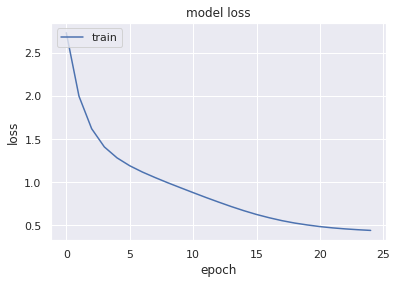

In [17]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [18]:
benchmark_rnn.summary()

Model: "custom_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  24064     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  96350     
                                                                 
Total params: 4,058,718
Trainable params: 4,058,718
Non-trainable params: 0
_________________________________________________________________


Generate Text

In [19]:
one_step_model = helpers.OneStep(benchmark_rnn, chars_from_ids, ids_from_chars)

In [20]:
# start = time.time()
states = None
next_char = tf.constant(['The'])
result = [next_char]

tf.random.set_seed(seed)
for n in range(100):
    next_char, states = one_step_model.generate_one_step(next_char, seed=seed, states=states)
    result.append(next_char)
    # print(next_char, states, '-'*30)

result = tf.strings.join(result)
# end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
# print('\nRun time:', end - start)

The Wwitmert and the area to help wime reports on clients for next quarter operating profit of 8.15 in  

________________________________________________________________________________


Save the RNN model

In [21]:
print('Saving RNN model for: ',df_name,'\n\n')
tf.saved_model.save(one_step_model, 'rnn_'+df_name)

Saving RNN model for:  news_data 




INFO:tensorflow:Assets written to: rnn_news_data/assets


INFO:tensorflow:Assets written to: rnn_news_data/assets


In [22]:
import pandas as pd
from tqdm import tqdm
rnn_reloaded = tf.saved_model.load('rnn_'+df_name)

In [23]:
test_result_name = 'gpt2_'+df_name[:-5]+'-test_result.csv'
test = pd.read_csv('./text_generation_results/'+df_name+'/'+test_result_name)

In [24]:
start = time.time()
avg_word_len = 5
buffer_num_word = 15

for row in tqdm(test.index):
    states = None
    # 1. get ``prefix`` and ``true_end_text``
    prefix = test.loc[row, 'prefix']
    
    # 2. generate text based on the prefix
    num_words = int(test.loc[row, 'num_words']+buffer_num_word)*avg_word_len
    next_char = tf.constant([prefix])
    result = [next_char]
    for char in range(num_words):
        next_char, states = rnn_reloaded.generate_one_step(next_char, seed, states=states)
        result.append(next_char)
    result = tf.strings.join(result)
    result_text = result[0].numpy().decode('utf-8')
    test.loc[row, 'rnn_text'] = ' '.join(result_text.split(' ')[len(prefix.split()):])

100%|██████████| 153/153 [05:03<00:00,  1.98s/it]


In [25]:
# test_result_name = 'gpt2_'+df_name[:-5]+'_'+today+'-test_result.csv'
test_result_name = 'gpt2_'+df_name[:-5]+'-test_result.csv'

# --------------------------------- saving in sageMaker -------------------------------
test.to_csv('./text_generation_results/'+df_name+'/'+test_result_name, index=False)
print(test_result_name+' with rnn results saved.')
# ---------------------------------------------------------------------------------

gpt2_news-test_result.csv with rnn results saved.


### 3.1.2 Evalualtion

In [2]:
import pandas as pd
from tqdm import tqdm

test_result_name = 'gpt2_'+df_name[:-5]+'-test_result.csv'
test = pd.read_csv('./text_generation_results/'+df_name+'/'+test_result_name)

In [3]:
import re

# Trim the sentences to the last punctuation (remove unfinished sentence)
for i in test.gpt2_text.index:
    # trim gpt2 generated text
    senquence_gpt2 = test.loc[i,'gpt2_text']
    test.loc[i,'gpt2_trimmed'] = ''.join(re.split("([.?!])", senquence_gpt2)[:-1])
    # trim rnn generated text
    senquence_rnn = test.loc[i,'rnn_text']
    test.loc[i,'rnn_trimmed'] = ''.join(re.split("([.?!])", senquence_rnn)[:-1])

In [4]:
# from datetime import date

# today = date.today().strftime("%b%d")
# print("Today's date:", today)

#### 3.1.2.1 BLEU

In [30]:
# Using BLEU score to compare the real sentences with the generated ones
import statistics
from nltk.translate.bleu_score import sentence_bleu

for i in tqdm(test.index):
    reference = test['true_end_text'][i]
    candidate_gpt2 = test['gpt2_text'][i]
    candidate_rnn = test['rnn_text'][i]

    test.loc[i,'gpt2_BLEU'] = sentence_bleu(reference, candidate_gpt2)
    test.loc[i,'rnn_BLEU'] = sentence_bleu(reference, candidate_rnn)

  0%|          | 0/153 [00:00<?, ?it/s]/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

#### 3.1.2.2 Grammar Check

In this section, we check for the grammar errors and the misspellings for the generated text with the help of the [`language_tool_python`]((https://pypi.org/project/language-tool-python/)) package. Note that to take generation lenght into account, we used "rate" instead of absolute numbers. That is, we devide the number of errors/misspellings with the number of words generated.

In [3]:
import language_tool_python
tool = language_tool_python.LanguageToolPublicAPI('en-US')

In [4]:
test[['gpt2_trimmed','rnn_trimmed']] = test[['gpt2_trimmed','rnn_trimmed']].fillna('')

In [5]:
from tqdm import tqdm
tqdm.pandas()

for i in tqdm(test.index):
    prefix = test.loc[i,'prefix']
    gpt2_trimmed = test.loc[i,'gpt2_trimmed']
    rnn_trimmed = test.loc[i,'rnn_trimmed']
    n_word_gpt2 = len(gpt2_trimmed.split())
    n_word_rnn = len(rnn_trimmed.split())
    gpt2_match = tool.check(prefix+gpt2_trimmed)
    rnn_match = tool.check(prefix+rnn_trimmed)

    test.loc[i,'gpt2_grammar_error'] = len(gpt2_match)/n_word_gpt2 if n_word_gpt2!=0 else 0
    test.loc[i,'rnn_grammar_error'] = len(rnn_match)/n_word_rnn if n_word_rnn!=0 else 0
    test.loc[i,'gpt2_misspelling'] = [match_object.ruleIssueType for match_object in gpt2_match].count(
        'misspelling')/n_word_gpt2 if n_word_gpt2!=0 else 0
    test.loc[i,'rnn_misspelling'] = [match_object.ruleIssueType for match_object in rnn_match].count(
        'misspelling')/n_word_rnn if n_word_rnn!=0 else 0
    
test.head(3)

100%|██████████| 153/153 [04:11<00:00,  1.64s/it]


,TITLE,URL,text,hasSpeialChar,num_words,prefix,true_end_text,gpt2_text,rnn_text,gpt2_trimmed,rnn_trimmed,gpt2_BLEU,rnn_BLEU,gpt2_grammar_error,rnn_grammar_error,gpt2_misspelling,rnn_misspelling
0,CDTi Added to the Russell Microcap Index,http://www.nasdaq.com/press-release/cdti-added...,Your symbols have been updated\n\nYou'll now b...,0,25,Your symbols have been,updated You'll now be able to see real-time p...,updated\n\n\nContinue The U.S. economy added...,updated\n\nYou'll now be able to request a cen...,updated\n\n\nContinue The U.S. economy added...,updated\n\nYou'll now be able to request a cen...,1.144672e-231,1.095313e-231,0.043478,0.100000,0.000000,0.100000
1,IMF's Christine Lagarde put under investigatio...,http://www.dnaindia.com/world/report-imf-s-chr...,IMF chief Christine Lagarde has been placed un...,0,180,IMF chief Christine Lagarde,has been placed under formal investigation by...,said the central bank will not raise interest...,had responsible eight down in you can. Fiat C...,said the central bank will not raise interest...,had responsible eight down in you can. Fiat C...,8.635657e-232,8.448571e-232,0.052632,0.136054,0.022556,0.122449
2,Asia Developing Economies to Grow at Slower Pa...,http://www.bloomberg.com/news/2014-04-07/asia-...,Why did this happen?\n\nPlease make sure your ...,0,35,Why did this happen?,Please make sure your browser supports JavaSc...,\n Why didn't you see it? Sign up to get the ...,make sure your browser supports JavaScript and...,\n Why didn't you see it? Sign up to get the ...,make sure your browser supports JavaScript and...,1.081918e-231,1.082142e-231,0.068966,0.029412,0.034483,0.000000


In [6]:
test[['gpt2_grammar_error','rnn_grammar_error','gpt2_misspelling','rnn_misspelling']].describe()

,gpt2_grammar_error,rnn_grammar_error,gpt2_misspelling,rnn_misspelling
count,153.000000,153.000000,153.000000,153.000000
mean,0.065689,0.113319,0.031180,0.087811
std,0.081833,0.055261,0.076000,0.053618
min,0.000000,0.000000,0.000000,0.000000
25%,0.036913,0.089686,0.006135,0.058824
50%,0.054054,0.112832,0.021277,0.092402
75%,0.068966,0.135802,0.034483,0.112069
max,0.666667,0.280000,0.666667,0.272727


In [7]:
# test_result_name = 'gpt2_'+df_name[:-5]+'_'+today+'-test_result.csv'
test_result_name = df_name[:-5]+'-test_result.csv'

# --------------------------------- saving in sageMaker -------------------------------
test.to_csv('./text_generation_results/'+df_name+'/'+test_result_name, index=False)
print(test_result_name+' with evaluation saved.')
# ---------------------------------------------------------------------------------

gpt2_news-test_result.csv with evaluation saved.


# 4. Empirical Results

### 4.1 Dataset-based Result

In this section, we present the evaluation results for the generated text from both GPT2 and the benchmark RNN. The table contains the three metrics we use in the experiment, namely the `BLEU`, `grammar_error` and `misspelling`.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import helper_function as helpers

lyrics_result = pd.read_csv('./text_generation_results/lyrics_data/lyrics-test_result.csv')
news_result = pd.read_csv('./text_generation_results/news_data/news-test_result.csv')
netflix_result = pd.read_csv('./text_generation_results/netflix_data/netflix-test_result.csv')

**Result for the news data**

For the news data, the results show that the `BLEU` scores attained from both models are essentially zero, given that all quantile intervals and the mean values are very close to zero. However, from `grammar_error`, GPT2 has lower error rate than the RNN model, which is consistent with the `misspelling` metric.

In [2]:
news_result[['gpt2_BLEU','rnn_BLEU',
             'gpt2_grammar_error','rnn_grammar_error',
             'gpt2_misspelling','rnn_misspelling']].describe()

,gpt2_BLEU,rnn_BLEU,gpt2_grammar_error,rnn_grammar_error,gpt2_misspelling,rnn_misspelling
count,1.530000e+02,1.530000e+02,153.000000,153.000000,153.000000,153.000000
mean,9.159424e-232,8.959405e-232,0.065689,0.113319,0.031180,0.087811
std,0.000000e+00,0.000000e+00,0.081833,0.055261,0.076000,0.053618
min,6.384507e-232,6.378027e-232,0.000000,0.000000,0.000000,0.000000
25%,7.693602e-232,7.568122e-232,0.036913,0.089686,0.006135,0.058824
50%,9.127039e-232,8.871923e-232,0.054054,0.112832,0.021277,0.092402
75%,1.081918e-231,1.052811e-231,0.068966,0.135802,0.034483,0.112069
max,1.209782e-231,1.135208e-231,0.666667,0.280000,0.666667,0.272727


**Result for the netflix data**

As for the netflix data, the `BLEU` scores from both models are also almost zero. Here, the average `grammar_error` rate and therefore average `misspelling` rate from GPT2 is noticeably low, while the RNN model yields considerably high rates.

In [4]:
netflix_result[['gpt2_BLEU','rnn_BLEU',
               'gpt2_grammar_error','rnn_grammar_error',
               'gpt2_misspelling','rnn_misspelling']].describe()

,gpt2_BLEU,rnn_BLEU,gpt2_grammar_error,rnn_grammar_error,gpt2_misspelling,rnn_misspelling
count,7.730000e+02,7.730000e+02,773.000000,773.000000,773.000000,773.000000
mean,1.116336e-231,1.056665e-231,0.014599,0.171066,0.011674,0.149359
std,0.000000e+00,0.000000e+00,0.040627,0.153273,0.037267,0.149284
min,1.020865e-231,9.701191e-232,0.000000,0.000000,0.000000,0.000000
25%,1.090755e-231,1.042315e-231,0.000000,0.083333,0.000000,0.062500
50%,1.113190e-231,1.054284e-231,0.000000,0.150000,0.000000,0.125000
75%,1.138999e-231,1.071296e-231,0.000000,0.230769,0.000000,0.200000
max,1.268852e-231,1.130270e-231,0.400000,1.000000,0.400000,1.000000


**Result for the lyrics data**

Lastly for the lyrics data, the `BLEU` score is again rather close to zero as in the previous two datasets. However, interestingly, `GPT2` model has average higher rates of `grammar_error` and `misspelling`, this is completely the opposite from the other datasets. Next on, we will further explore why this is case for the lyrics dataset.

In [5]:
lyrics_result[['gpt2_BLEU','rnn_BLEU',
               'gpt2_grammar_error','rnn_grammar_error',
               'gpt2_misspelling','rnn_misspelling']].describe()

,gpt2_BLEU,rnn_BLEU,gpt2_grammar_error,rnn_grammar_error,gpt2_misspelling,rnn_misspelling
count,2.900000e+02,2.900000e+02,290.000000,290.000000,290.000000,290.000000
mean,7.850717e-232,7.198623e-232,0.167243,0.134532,0.076806,0.063922
std,0.000000e+00,0.000000e+00,0.054328,0.028102,0.053429,0.022349
min,6.329867e-232,6.021398e-232,0.046875,0.078014,0.000000,0.029412
25%,7.289179e-232,6.824123e-232,0.129888,0.117245,0.038918,0.050696
50%,7.669571e-232,7.093379e-232,0.164771,0.133333,0.069643,0.061758
75%,8.311280e-232,7.548777e-232,0.201042,0.147170,0.109635,0.072756
max,1.026206e-231,8.754153e-232,0.451149,0.346154,0.390805,0.276923


Taking a random sample of the generated text, we can easily see that the `GPT2` model picks up the lyrics-style of writing from the fine-tuning dataset, that is, it contains more informal spellings, e.g. <font color='blue'>because of ya'</font>,  <font color='blue'>ain' t nobody</font>, <font color='blue'>touch 'em</font>, <font color='blue'>lovin girl</font> etc. And some of these are considered as misspellings in the ``language_tool_python`` package.

In [81]:
seed = 1
idx = lyrics_result.sample(1, random_state=seed).index.values[0]
print('misspelling rate: ', lyrics_result.gpt2_misspelling[idx], '\n\n', lyrics_result.gpt2_trimmed[idx],'\n\n')

import language_tool_python
tool = language_tool_python.LanguageToolPublicAPI('en-US')
match = tool.check(lyrics_result.prefix[idx]+lyrics_result.gpt2_trimmed[idx])
print('-'*30,' lovin is considered as a misspelling ','-'*30)
match[20]

misspelling rate:  0.1157407407407407 

  more than just walk away. But now, baby, what am i supposed to do? (do). When your heart's in pain and its not working out for me?. Baby, don't cry anymore  You're so beautiful,. Beautiful.. And when we kiss there'll be no tears left behind. So much love is waiting here tonight!. Ohh ohhh.... [Chorus:]. It doesn`t matter who sees or hears us cause they all agree on this one thing:. We are gonna make history together...in my lifetime!(oh yeah!). No need to hide from them eyes because of ya' beauty!!!!![Verse 2:]. The way she moves her body makes everything feel real right..... She got alot of energy inside but ain´ t nobody can touch 'em till after midnight......she gettin hot as hell with every breath thats taken....... Girl if u want some lovin girl then come over babe let him take care of yo hair down below.... He won’ve gotta have his girls ready wit dat boyy style..ah ahaha he really wanna see yall shawty look good too...when ima put dem cl

Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'message': 'Possible spelling mistake found.', 'replacements': ['loving', 'login', 'loin'], 'offsetInContext': 43, 'context': '... thats taken....... Girl if u want some lovin girl then come over babe let him take c...', 'offset': 913, 'errorLength': 5, 'category': 'TYPOS', 'ruleIssueType': 'misspelling', 'sentence': 'Girl if u want some lovin girl then come over babe let him take care of yo hair down below....'})

Further more, the extracted text below is the one with the highest misspelling rate, we can see that starting from the sixth line, there are a series of <font color='blue'>non-english words</font> coming up, resulting in the high amount of misspellings detected from the text.

In [9]:
print(lyrics_result[lyrics_result.gpt2_misspelling>0.39].gpt2_trimmed.values[0])

 back like we did before,. Girl you got the best time of your life (time of yours). And if u want to party with my crew tonight baby let them have fun!. [Chorus]. Cause when they see what i've been doin'. They gonna say fuck dat bitch and leave her alone.. When she come around here wanna dance wit ya boy(yeah)  You're so beautiful but not quite as good at making love. So damn cute is how these little things look on their face. But there are times where everything seems fine for now. It doesn’t matter who sees or hears about our troubles anymore. There will be tears left behind by tomorrow morning sun. If only all those lonely nights were forever ago today. Oh ohh.... The way he smiles makes every single one cry again. He can make everyone feel alive somehow... Yeah!. Chrous: Enrique Iglesias - El Clásico de Hoyo y Ciudad Juárez por la Familia Nacional e Maria Lara Peronza Estrada Y Comúnica para el Pais Vasco da Tinto en Espíritos o mio que se llama no es su casillas ahora comida aqui 

### 4.2 Cross-Dataset Results

Next up, we plot the graphs from the evalution metric values to get a better view on the cross-dataset results.

**BLEU Score**

From graph 1, we confirm with our observation from the previous tables: with the scale of the y-axis being "1e-231", it's shown that the `BLEU` scores are only fluctuating around zero for all models and datasets.

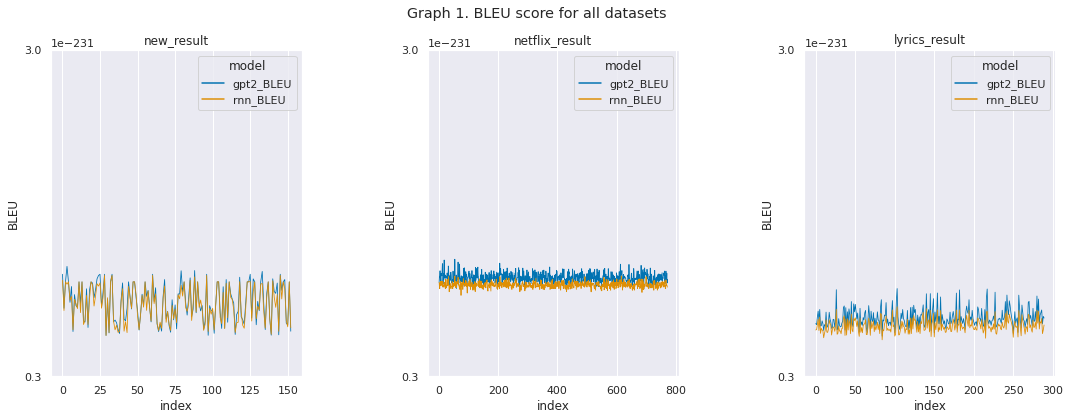

In [10]:
helpers.plot_results_bleu(data1=news_result, data2=netflix_result, data3=lyrics_result)

**Grammar Error Rate**

Checking for the next metric, we can see that GPT2-generated text yields lower rates of `grammar_error` than RNN-generated text for netflix and news dataset, but quite the opposite for lyrics dataset. Furthermore, within all three datasets, GPT2 model fine-tuned on the netflix data produce the lowest grammatical error rates, given the mean value being almost zero, while the RNN one fine-tuned on the smae data for lyrics data produce the highest rate.

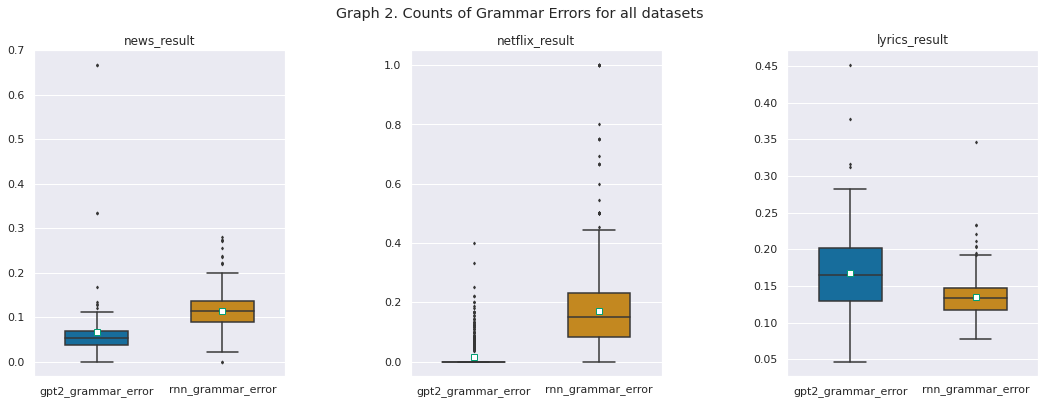

In [11]:
helpers.plot_results_gmerr(data1=news_result, data2=netflix_result, data3=lyrics_result)

**Misspelling Rate**

Coming from `grammar_error`, its subset `misspelling` generally indicates the same tendency across three datasets. Nevertheless, compared to the `grammar_error` rate, here the `misspelling` rate for news data remains similar, while the one for lyrics data dramatically decreased, meaning that the grammar errors in news datasets are mostly misspellings and in lyrics data not.

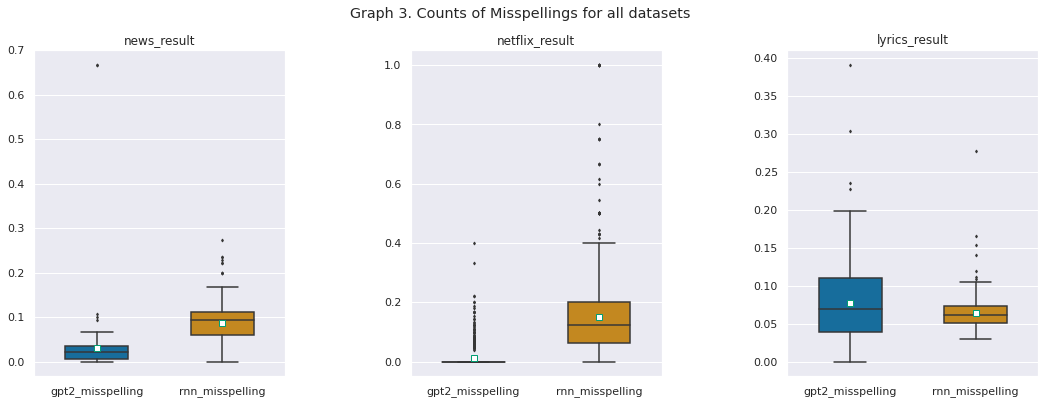

In [12]:
helpers.plot_results_missp(data1=news_result, data2=netflix_result, data3=lyrics_result)

# 5. Discussion

From the empirical results, we can see that the BLEU scores from all models and all datasets are essentially zero. BLEU was originally developed to evaluate machine translation, with values closer to one representing more similar texts and to zero otherwise. The aim of BLEU score is to gauge the similarity between the generated and the reference text. Yet, given that the develpoment of the text is not controlled in random text generation, the generated text can be grammatically correct and makes perfect sense but still receives a bad score - due to the generation of a complete different content, as we see from the results of netflix-GPT2. Clearly, despite its popularity among natural language processing tasks, the metric cannot appropriately reflect the model performance in our case. Consequently, we utilized the [`language_tool_python`](https://pypi.org/project/language-tool-python/) package to measure how many grammar errors are carried by the generated text. On top of that, given that lyrics don't necesarrily have strict grammar structures, we took a subset of the grammar error, the number of misspelling, for a better understanding on the lyrics generation. 

With the rate of grammar errors and misspellings, we observed the followings. First, GPT2 outperfroms the RNN model for two out of three datasets, with the average rate of grammar errors and misspellings from the GPT2-generated text being lower than the RNN-generated one. Second, the performance of the generation highly depends on the fine-tuning dataset. The results from GPT2 show high variations in terms of grammatical structures, with netflix model comprising nearly no grammar mistakes and misspellings, and the lyrcis carrying a high rate of mistakes. Two highly possible reasons for this are the informal writing-style of lytics text and the mingling of non-English part of lyrics into the dataset. Both characteristics of the lyrics dataset give rise to the poor performance indication, whereas this doesn't necessarily mean the generation has low quality. Further research on a better metric for this kind of "loose-structured" and "mixed-language" text is needed to give a more objective judgement on the text quality.

# 6. Conclusion

Text generation is central to many NLP tasks, including machine translation, question answering and text summarization, and transformer-based neural language models trained on a sufficiently large and diverse dataset have shown to be very successful across many domains and datasets. The goal of this paper is to apply python implementations for transformer-based text generation model and compare the generated text with other architectures. In the paper, we included two models, GPT2 and a benchmark RNN, and three datasets: Netflix description, Pop-Song Lyrics, and Business News. To evaluate the generated text, we applied three metrics, including BLEU, grammar_error rate and misspelling rate. Due to the unsuitability of the BLEU score in our case, we mostly rely on the later two for the model performance.

The results from the experiment showcased that GPT2 outperfroms RNN on the news and netflix dataset, with the judgement for lyrics data being held back since the a grammar check on informal text could be inappropriate. And with its strong ability to pick up text style, GPT2 produced lyrics-alike text but was considered carrying many mistakes. Despite that, we see that for better-stuctured text like news or normal sentence like netflix description, GPT2 can surely deliver better text than the RNN model.

# 7. Reference

[Bahdanau et al., 2014] 

&ensp;&ensp;&ensp; *Bahdanau, D., Cho, K., and Bengio, Y. (2014).
Neural machine translation by jointly learning to align and translate. arXiv
preprint arXiv:1409.0473.*

[Celikyilmaz et al., 2020] 

&ensp;&ensp;&ensp; *Celikyilmaz, A., Clark, E., and Gao, J. (2020).
Evaluation of text generation: A survey. arXiv preprint arXiv:2006.14799.*

[Chen et al., 2016] 

&ensp;&ensp;&ensp; *Chen, X., Duan, Y., Houthooft, R., Schulman, J.,
Sutskever, I., and Abbeel, P. (2016). Infogan: Interpretable representation
learning by information maximizing generative adversarial nets. Advances
in neural information processing systems, 29.*

[Chung et al., 2014] 

&ensp;&ensp;&ensp; *Chung, J., Gulcehre, C., Cho, K., and Bengio, Y. (2014).
Empirical evaluation of gated recurrent neural networks on sequence
modeling. arXiv preprint arXiv:1412.3555.*

[Gatt et al., 2007] 

&ensp;&ensp;&ensp; *Gatt, A., Van Der Sluis, I., and Van Deemter, K. (2007).
Evaluating algorithms for the generation of referring expressions using a
balanced corpus. Association for Computational Linguistics.*

[Hochreiter and Schmidhuber, 1997] 

&ensp;&ensp;&ensp; *Hochreiter, S. and Schmidhuber, J.
(1997). Long short-term memory. Neural computation, 9(8):1735–1780.*

[Holtzman et al., 2019] 

&ensp;&ensp;&ensp; *Holtzman, A., Buys, J., Du, L., Forbes, M., and Choi,
Y. (2019). The curious case of neural text degeneration. arXiv preprint
arXiv:1904.09751.*

[Keskar et al., 2019] 

&ensp;&ensp;&ensp; *Keskar, N. S., McCann, B., Varshney, L. R., Xiong, C.,
and Socher, R. (2019). Ctrl: A conditional transformer language model
for controllable generation. arXiv preprint arXiv:1909.05858.*

[Konstas and Lapata, 2013] 

&ensp;&ensp;&ensp; *Konstas, I. and Lapata, M. (2013). A global
model for concept-to-text generation. Journal of Artificial Intelligence
Research, 48:305–346.*

[Lample et al., 2017] 

&ensp;&ensp;&ensp; *Lample, G., Zeghidour, N., Usunier, N., Bordes, A.,
Denoyer, L., and Ranzato, M. (2017). Fader networks: Manipulating
images by sliding attributes. Advances in neural information processing
systems, 30.*
[Mairesse et al., 2010] 

&ensp;&ensp;&ensp; *Mairesse, F., Gasic, M., Jurcicek, F., Keizer, S.,
Thomson, B., Yu, K., and Young, S. (2010). Phrase-based statistical
language generation using graphical models and active learning. In Pro-
ceedings of the 48th Annual Meeting of the Association for Computational
Linguistics, pages 1552–1561.*

[Marcu, 1997]

&ensp;&ensp;&ensp; *Marcu, D. (1997). From discourse structures to text sum-
maries. In Intelligent Scalable Text Summarization.*

[Nallapati et al., 2016]

&ensp;&ensp;&ensp; *Nallapati, R., Zhou, B., Gulcehre, C., Xiang, B., et al.
(2016). Abstractive text summarization using sequence-to-sequence rnns
and beyond. arXiv preprint arXiv:1602.06023.*

[Ono et al., 1994] 

&ensp;&ensp;&ensp; *Ono, K., Sumita, K., Research, S. M., Center, D.,
Komukai-Toshiba-cho, T. C., et al. (1994). Abstract generation based on
rhetorical structure extraction. arXiv preprint cmp-lg/9411023.*

[Paige et al., 2017] 

&ensp;&ensp;&ensp; *Paige, B., van de Meent, J.-W., Desmaison, A., Good-
man, N., Kohli, P., Wood, F., Torr, P., et al. (2017). Learning disentangled
representations with semi-supervised deep generative models. Advances in
neural information processing systems, 30.*

[Peng et al., 2018] 

&ensp;&ensp;&ensp; *Peng, N., Ghazvininejad, M., May, J., and Knight, K.
(2018). Towards controllable story generation. In Proceedings of the First
Workshop on Storytelling, pages 43–49.*

[Radford et al., 2019] 

&ensp;&ensp;&ensp; *Radford, A., Wu, J., Child, R., Luan, D., Amodei, D.,
Sutskever, I., et al. (2019). Language models are unsupervised multitask
learners. OpenAI blog, 1(8):9.*

[Reiter and Dale, 1997] 

&ensp;&ensp;&ensp; *Reiter, E. and Dale, R. (1997). Building applied
natural language generation systems. Natural Language Engineering,
3(1):57–87.*

[Stede and Umbach, 1998] 

&ensp;&ensp;&ensp; *Stede, M. and Umbach, C. (1998). Dimlex: A
lexicon of discourse markers for text generation and understanding. In
COLING 1998 Volume 2: The 17th International Conference on Compu-
tational Linguistics.*

[Uchendu et al., 2020] 

&ensp;&ensp;&ensp; *Uchendu, A., Le, T., Shu, K., and Lee, D. (2020).
Authorship attribution for neural text generation. In Conf. on Empirical
Methods in Natural Language Processing (EMNLP).*

[Vaswani et al., 2017] 

&ensp;&ensp;&ensp; *Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J.,
Jones, L., Gomez, A. N., Kaiser, Ł., and Polosukhin, I. (2017). Attention
is all you need. Advances in neural information processing systems, 30.*

[Welleck et al., 2019] 

&ensp;&ensp;&ensp; *Welleck, S., Kulikov, I., Roller, S., Dinan, E., Cho, K.,
and Weston, J. (2019). Neural text generation with unlikelihood training.
arXiv preprint arXiv:1908.04319.*

[Wiseman et al., 2017]

&ensp;&ensp;&ensp; *Wiseman, S., Shieber, S. M., and Rush, A. M.
(2017). Challenges in data-to-document generation. arXiv preprint
arXiv:1707.08052.*